In [1]:
library('tidyverse')
library(sf)
theme_set(theme_bw())

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.0     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()
Linking to GEOS 3.7.1, GDAL 2.4.0, PROJ 5.2.0


I want to study how socioeconomic conditions have changed in democrat and republican controlled house districts over the past decade.

I used the [American FactFinder](https://factfinder.census.gov/faces/nav/jsf/pages/index.xhtml) to get economic information for 2005 and 2017 by congressional district.

The data are stored in the `acs/` subfolder:

In [2]:
dir('acs/2005')

[1] "ACS_05_EST_DP3_metadata.csv" "ACS_05_EST_DP3.csv"         
[3] "ACS_05_EST_DP3.txt"          "ACS_05_EST_DP3.zip"         
[5] "aff_download_readme.txt"    

The table has been broken up into three files. `ACS_05_EST_DP3_metadata.csv` contains column definitions:

In [9]:
meta_2005 <- read_csv("acs/2005//ACS_05_EST_DP3_metadata.csv") %>% as_tibble %>% print

Parsed with column specification:
cols(
  GEO.id = col_character(),
  Id = col_character()
)


# A tibble: 226 x 2
   GEO.id          Id                                                           
   <chr>           <chr>                                                        
 1 GEO.id2         Id2                                                          
 2 GEO.display-la… Geography                                                    
 3 EST_VC02        Estimate; EMPLOYMENT STATUS - Population 16 years and over   
 4 MOE_VC02        Margin of Error; EMPLOYMENT STATUS - Population 16 years and…
 5 EST_VC03        Estimate; EMPLOYMENT STATUS - Population 16 years and over -…
 6 MOE_VC03        Margin of Error; EMPLOYMENT STATUS - Population 16 years and…
 7 EST_VC04        Estimate; EMPLOYMENT STATUS - Population 16 years and over -…
 8 MOE_VC04        Margin of Error; EMPLOYMENT STATUS - Population 16 years and…
 9 EST_VC05        Estimate; EMPLOYMENT STATUS - Population 16 years and over -…
10 MOE_VC05        Margin of Error; EMPLOYMENT STATUS - Population 16 years and…
# … with

Here are some variables that have to do with income:

In [11]:
meta_2005 %>% filter(str_detect(Id, "INCOME")) %>% print

# A tibble: 126 x 2
   GEO.id   Id                                                                  
   <chr>    <chr>                                                               
 1 EST_VC56 Estimate; INCOME AND BENEFITS (IN 2005 INFLATION-ADJUSTED DOLLARS) …
 2 MOE_VC56 Margin of Error; INCOME AND BENEFITS (IN 2005 INFLATION-ADJUSTED DO…
 3 EST_VC57 Estimate; INCOME AND BENEFITS (IN 2005 INFLATION-ADJUSTED DOLLARS) …
 4 MOE_VC57 Margin of Error; INCOME AND BENEFITS (IN 2005 INFLATION-ADJUSTED DO…
 5 EST_VC58 Estimate; INCOME AND BENEFITS (IN 2005 INFLATION-ADJUSTED DOLLARS) …
 6 MOE_VC58 Margin of Error; INCOME AND BENEFITS (IN 2005 INFLATION-ADJUSTED DO…
 7 EST_VC59 Estimate; INCOME AND BENEFITS (IN 2005 INFLATION-ADJUSTED DOLLARS) …
 8 MOE_VC59 Margin of Error; INCOME AND BENEFITS (IN 2005 INFLATION-ADJUSTED DO…
 9 EST_VC60 Estimate; INCOME AND BENEFITS (IN 2005 INFLATION-ADJUSTED DOLLARS) …
10 MOE_VC60 Margin of Error; INCOME AND BENEFITS (IN 2005 INFLATION-ADJUSTED DO…
# … with

Row 23 looks useful:

In [6]:
meta_2005 %>% filter(str_detect(Id, "INCOME")) %>% slice(23)

  GEO.id  
1 EST_VC67
  Id                                                                                                                       
1 Estimate; INCOME AND BENEFITS (IN 2005 INFLATION-ADJUSTED DOLLARS) - Total households - Median household income (dollars)

Let's extract this variable from the data table:

In [12]:
income_2005 <- read_csv("acs/2005/ACS_05_EST_DP3.csv") %>% select(1:3, EST_VC67) %>% print

Parsed with column specification:
cols(
  .default = col_double(),
  GEO.id = col_character(),
  GEO.id2 = col_character(),
  `GEO.display-label` = col_character()
)
See spec(...) for full column specifications.


# A tibble: 437 x 4
   GEO.id       GEO.id2 `GEO.display-label`                             EST_VC67
   <chr>        <chr>   <chr>                                              <dbl>
 1 5000900US01… 0101    Congressional District 1 (109th Congress), Ala…    36726
 2 5000900US01… 0102    Congressional District 2 (109th Congress), Ala…    36139
 3 5000900US01… 0103    Congressional District 3 (109th Congress), Ala…    33156
 4 5000900US01… 0104    Congressional District 4 (109th Congress), Ala…    33917
 5 5000900US01… 0105    Congressional District 5 (109th Congress), Ala…    41494
 6 5000900US01… 0106    Congressional District 6 (109th Congress), Ala…    52302
 7 5000900US01… 0107    Congressional District 7 (109th Congress), Ala…    27409
 8 5000900US02… 0200    Congressional District (at Large) (109th Congr…    56234
 9 5000900US04… 0401    Congressional District 1 (109th Congress), Ari…    36555
10 5000900US04… 0402    Congressional District 2 (109th Congress), Ari…    48006
# … with

## Mapping

Let's plot this by congressional district. The file `shapefiles/109/districts109.shp` is a *shapefile*. Think of it as a tibble that also contains mapping information. We use a special command called `st_read()` to load this file:

In [14]:
dist_109 <- st_read("shapefiles/109/districts109.shp") %>% print

Reading layer `districts109' from data source `/Users/terhorst/Dropbox/Michigan/Teaching/STATS/306/lectures/lectures/.census/shapefiles/109/districts109.shp' using driver `ESRI Shapefile'
Simple feature collection with 436 features and 15 fields (with 1 geometry empty)
geometry type:  MULTIPOLYGON
dimension:      XY
bbox:           xmin: -179.1473 ymin: 18.9177 xmax: 179.7785 ymax: 71.35256
epsg (SRID):    4269
proj4string:    +proj=longlat +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +no_defs
Simple feature collection with 436 features and 15 fields (with 1 geometry empty)
geometry type:  MULTIPOLYGON
dimension:      XY
bbox:           xmin: -179.1473 ymin: 18.9177 xmax: 179.7785 ymax: 71.35256
epsg (SRID):    4269
proj4string:    +proj=longlat +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +no_defs
First 10 features:
   STATENAME           ID DISTRICT STARTCONG ENDCONG DISTRICTSI COUNTY PAGE
1    Florida 012108112021       21       108     112       <NA>   <NA> <NA>
2   Arkansas 005108112003        3   

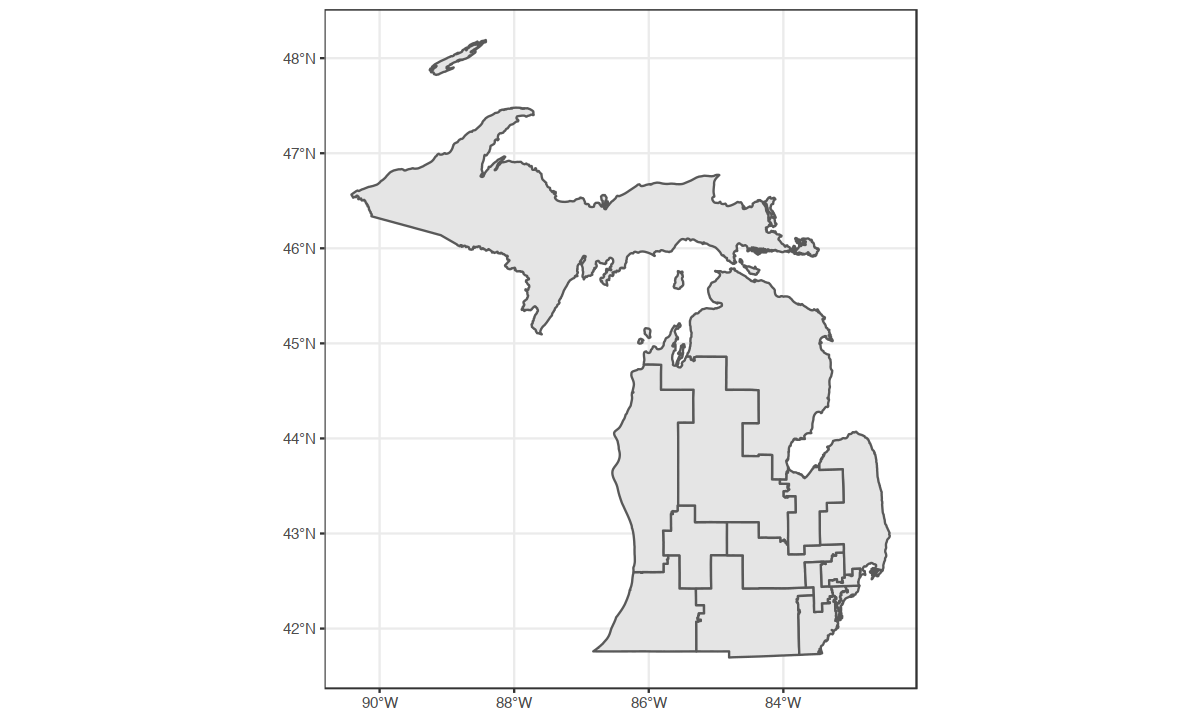

In [15]:
filter(dist_109, STATENAME == "Michigan") %>% ggplot + geom_sf()

Let's try making a map of the median household income for each congressional district. To do this, we need to join our tables `income_2005` and `dist_109`. What should our key be?

In [22]:
income_2005 %>% filter(str_detect(`GEO.display-label`, "Michigan")) %>% head(1)

  GEO.id        GEO.id2 GEO.display-label                                  
1 5000900US2601 2601    Congressional District 1 (109th Congress), Michigan
  EST_VC67
1 35979   

In [23]:
filter(dist_109, STATENAME == "Michigan", DISTRICT == 1)

  STATENAME ID           DISTRICT STARTCONG ENDCONG DISTRICTSI COUNTY PAGE LAW
1 Michigan  026108112001 1        108       112     NA         NA     NA   NA 
  NOTE BESTDEC FINALNOTE                  RNOTE LASTCHANGE                
1 NA   NA      {"From US Census website"} NA    2016-05-29 16:44:10.857626
  FROMCOUNTY geometry                      
1 F          MULTIPOLYGON (((-88.81079 4...

In [39]:
dist_109 %>% mutate(acs_id = str_c(str_sub(ID, 2, 3), str_sub(ID, -2))) %>% 
    filter(STATENAME == "Michigan", DISTRICT == 1)

  STATENAME ID           DISTRICT STARTCONG ENDCONG DISTRICTSI COUNTY PAGE LAW
1 Michigan  026108112001 1        108       112     NA         NA     NA   NA 
  NOTE BESTDEC FINALNOTE                  RNOTE LASTCHANGE                
1 NA   NA      {"From US Census website"} NA    2016-05-29 16:44:10.857626
  FROMCOUNTY geometry                       acs_id
1 F          MULTIPOLYGON (((-88.81079 4... 2601  

In [41]:
inc_cd_109 <- dist_109 %>% mutate(acs_id = str_c(str_sub(ID, 2, 3), str_sub(ID, -2))) %>% 
    left_join(income_2005, by = c(acs_id = "GEO.id2")) %>% print

Simple feature collection with 436 features and 19 fields (with 1 geometry empty)
geometry type:  MULTIPOLYGON
dimension:      XY
bbox:           xmin: -179.1473 ymin: 18.9177 xmax: 179.7785 ymax: 71.35256
epsg (SRID):    4269
proj4string:    +proj=longlat +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +no_defs
First 10 features:
   STATENAME           ID DISTRICT STARTCONG ENDCONG DISTRICTSI COUNTY PAGE
1    Florida 012108112021       21       108     112       <NA>   <NA> <NA>
2   Arkansas 005108112003        3       108     112       <NA>   <NA> <NA>
3    Florida 012108112017       17       108     112       <NA>   <NA> <NA>
4    Florida 012108112018       18       108     112       <NA>   <NA> <NA>
5    Florida 012108112020       20       108     112       <NA>   <NA> <NA>
6    Florida 012108112022       22       108     112       <NA>   <NA> <NA>
7    Florida 012108112023       23       108     112       <NA>   <NA> <NA>
8    Florida 012108112024       24       108     112       <NA>   <NA> 

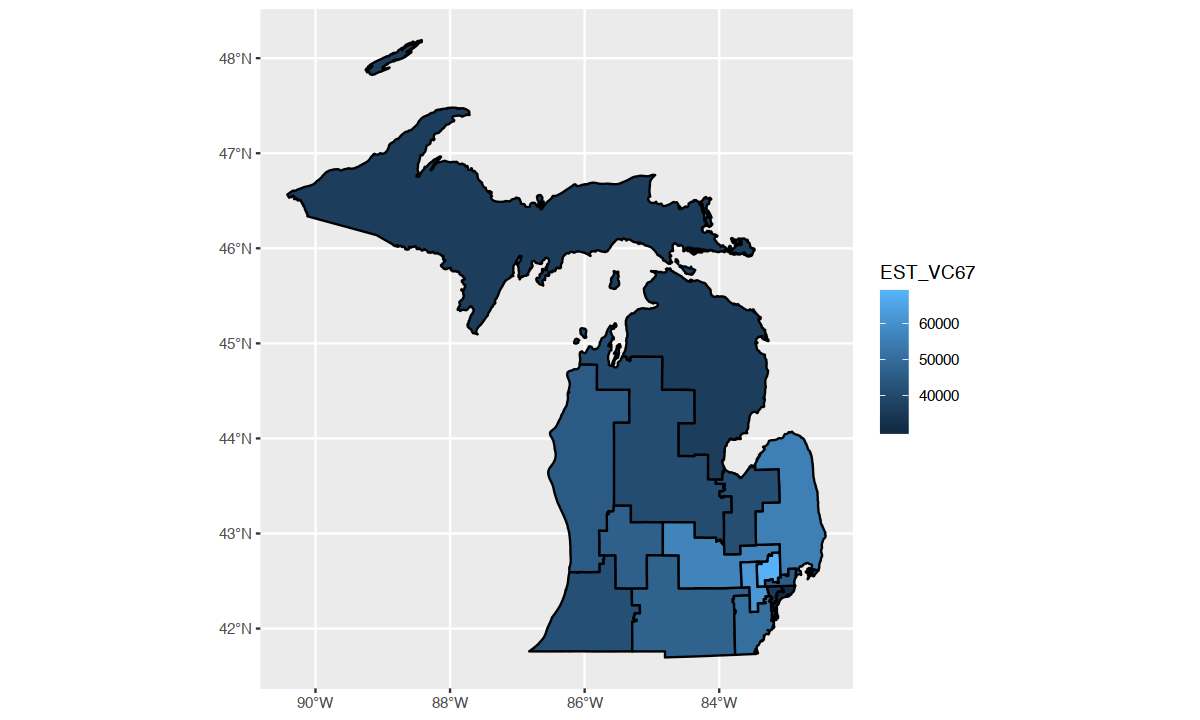

In [42]:
filter(inc_cd_109, STATENAME == "Michigan") %>% ggplot + geom_sf(aes(fill = EST_VC67), color="black")

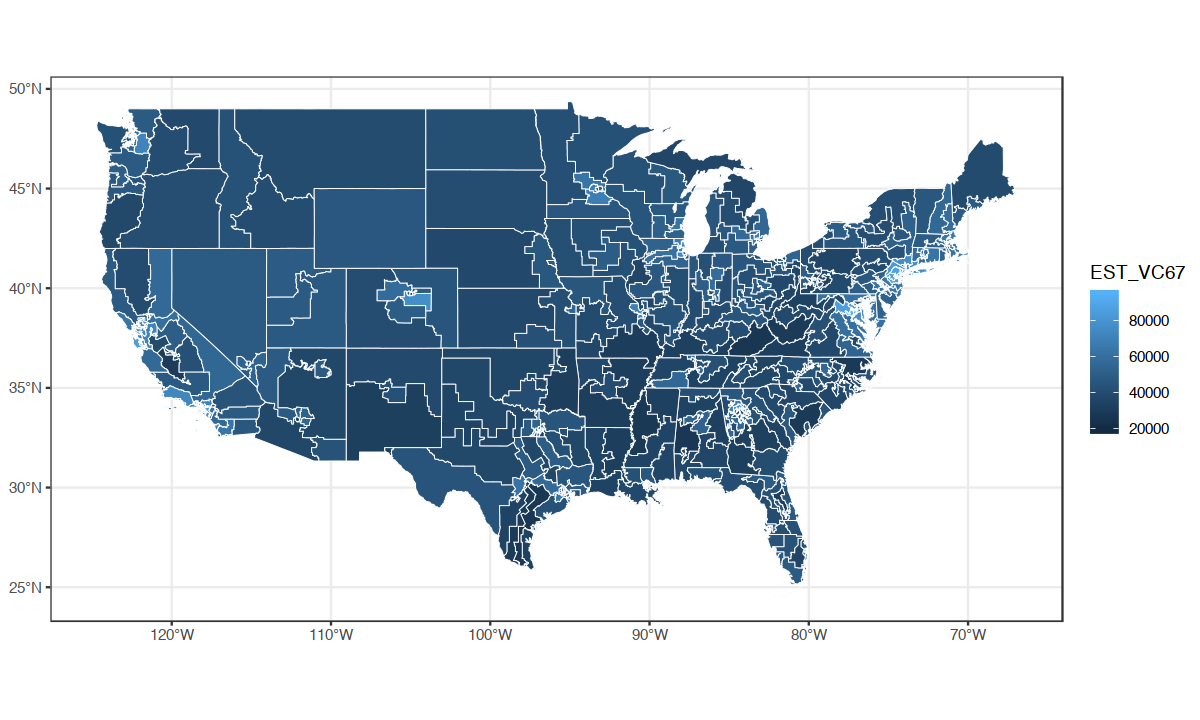

In [174]:
inc_cd_109_conus <- filter(inc_cd_109, STATENAME %in% state.name, 
       STATENAME != "Alaska", 
       STATENAME != "Hawaii") 
inc_cd_109_conus %>%
    ggplot() + geom_sf(aes(fill = EST_VC67), color="white", size=.2)

In [97]:
cong_inc_party_109 <- left_join(inc_cd_109_conus, cong_distr_109)

Joining, by = c("STATENAME", "DISTRICT")
Warning message:
“Column `STATENAME` joining factor and character vector, coercing into character vector”Warning message:
“Column `DISTRICT` joining factors with different levels, coercing to character vector”

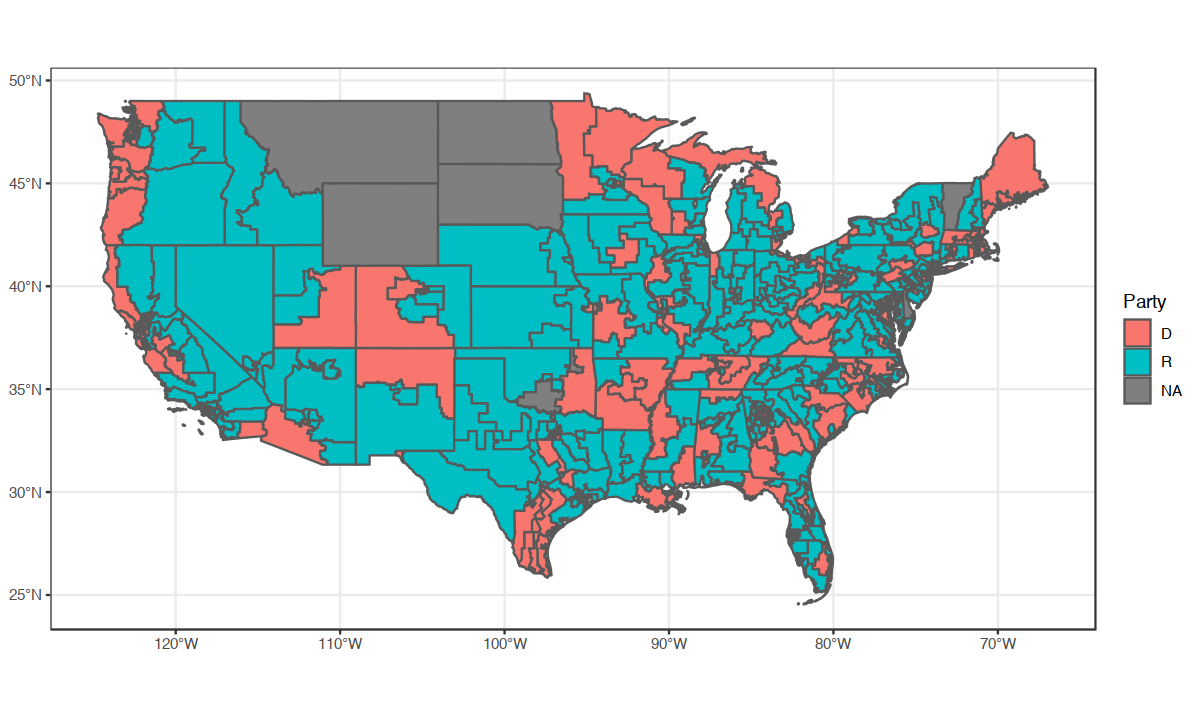

In [98]:
ggplot(cong_inc_party_109) + geom_sf(aes(fill=Party)) + theme_bw()

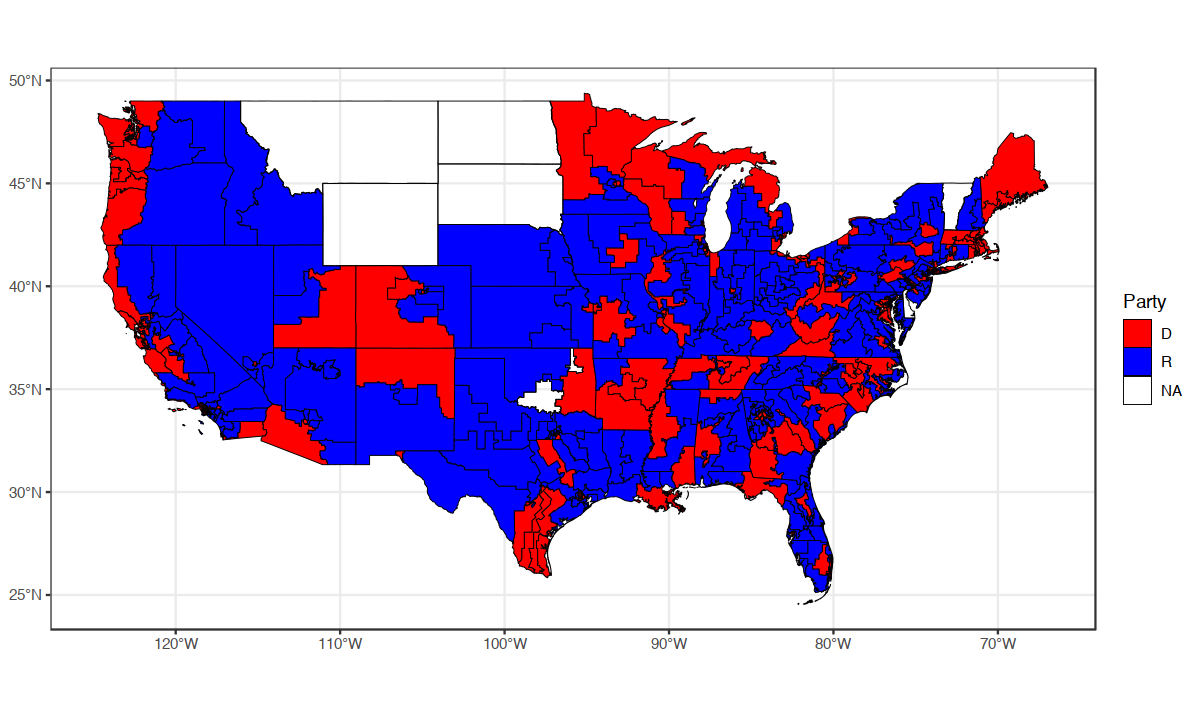

In [102]:
ggplot(cong_inc_party_109) + geom_sf(aes(fill=Party), color="black", size=.2) + theme_bw() + 
    scale_fill_manual(values = c("red", "blue"))

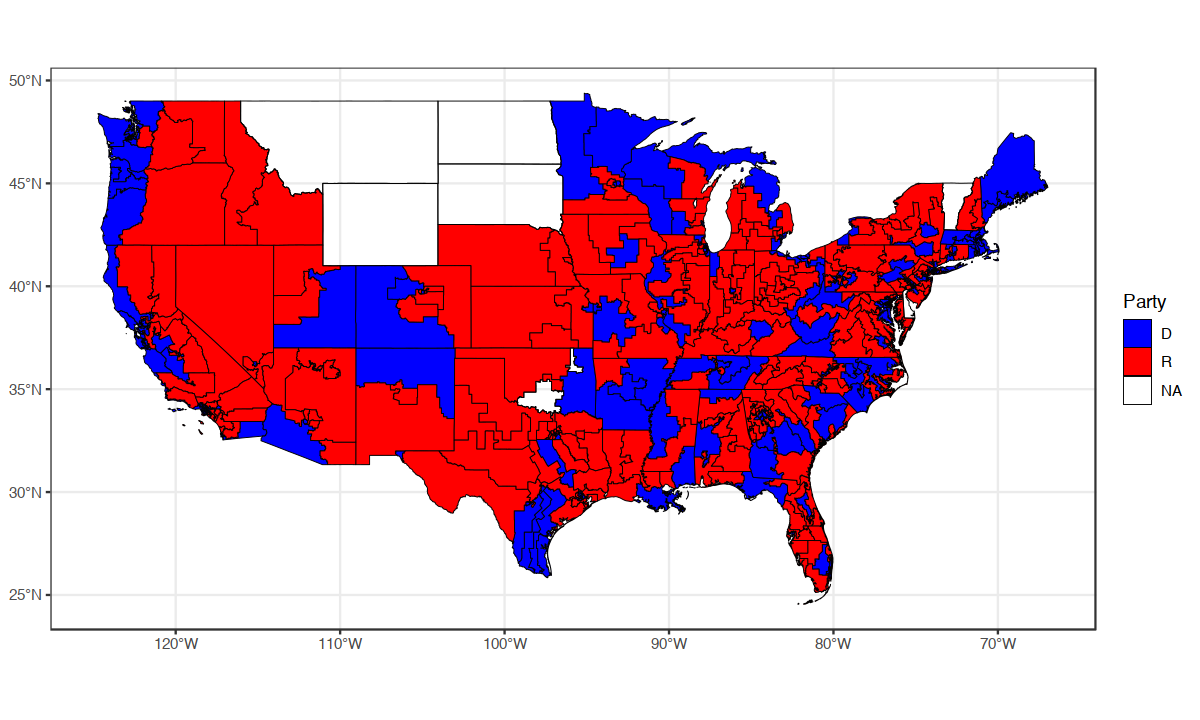

In [103]:
ggplot(cong_inc_party_109) + geom_sf(aes(fill=Party), color="black", size=.2) + theme_bw() + 
    scale_fill_manual(values = c("blue", "red"))

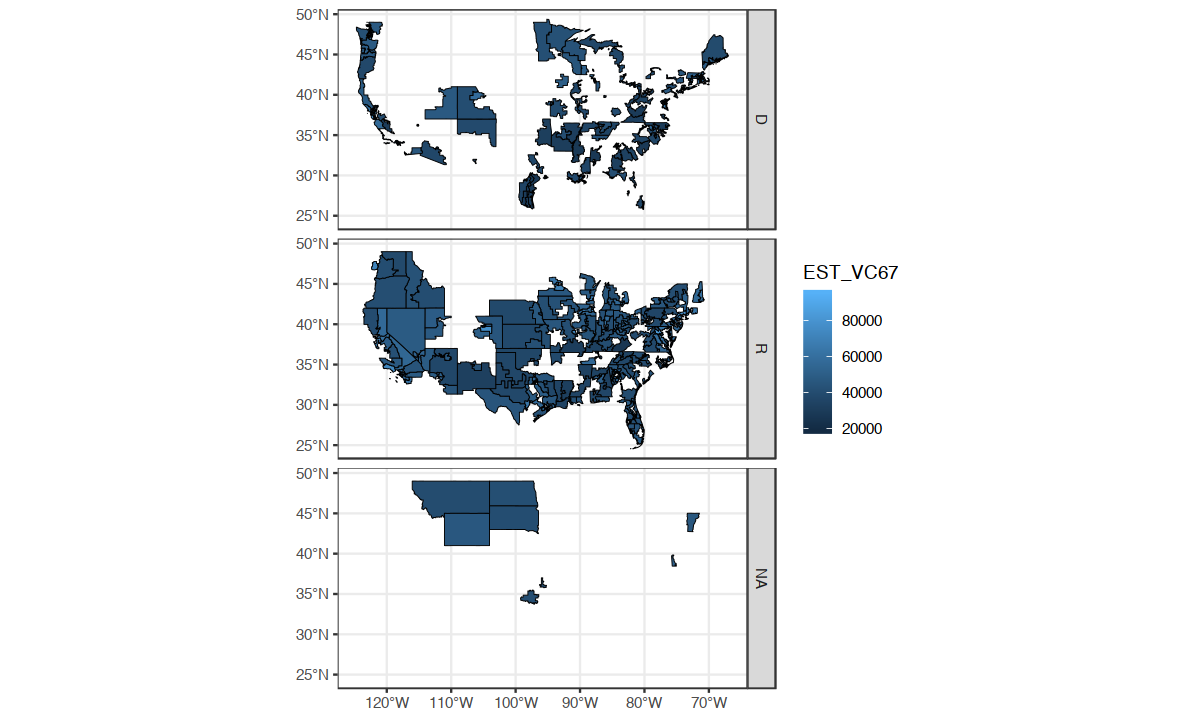

In [113]:
ggplot(cong_inc_party_109) + geom_sf(aes(fill=EST_VC67), color="black", size=.2) + theme_bw() + 
    facet_grid(Party ~ .)

## 2017 Data

In [16]:
dir('acs/2017')

[1] "ACS_17_1YR_DP03_ann.csv"      "ACS_17_1YR_DP03_metadata.csv"
[3] "ACS_17_1YR_DP03.csv"          "ACS_17_1YR_DP03.txt"         
[5] "ACS_17_1YR_DP03.zip"          "aff_download_readme.txt"     

In [17]:
meta_2017 <- read_csv("acs/2017/ACS_17_1YR_DP03_metadata.csv") %>% as_tibble %>% print

Parsed with column specification:
cols(
  GEO.id = col_character(),
  Id = col_character()
)


# A tibble: 550 x 2
   GEO.id          Id                                                           
   <chr>           <chr>                                                        
 1 GEO.id2         Id2                                                          
 2 GEO.display-la… Geography                                                    
 3 HC01_VC03       Estimate; EMPLOYMENT STATUS - Population 16 years and over   
 4 HC02_VC03       Margin of Error; EMPLOYMENT STATUS - Population 16 years and…
 5 HC03_VC03       Percent; EMPLOYMENT STATUS - Population 16 years and over    
 6 HC04_VC03       Percent Margin of Error; EMPLOYMENT STATUS - Population 16 y…
 7 HC01_VC04       Estimate; EMPLOYMENT STATUS - Population 16 years and over -…
 8 HC02_VC04       Margin of Error; EMPLOYMENT STATUS - Population 16 years and…
 9 HC03_VC04       Percent; EMPLOYMENT STATUS - Population 16 years and over - …
10 HC04_VC04       Percent Margin of Error; EMPLOYMENT STATUS - Population 16 y…
# … with

We again need to hunt around for the appropriate variable.

In [19]:
filter(meta_2017, str_detect(str_to_lower(Id), "median")) %>% print

# A tibble: 24 x 2
   GEO.id     Id                                                                
   <chr>      <chr>                                                             
 1 HC01_VC85  Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS…
 2 HC02_VC85  Margin of Error; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED …
 3 HC03_VC85  Percent; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS)…
 4 HC04_VC85  Percent Margin of Error; INCOME AND BENEFITS (IN 2017 INFLATION-A…
 5 HC01_VC114 Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS…
 6 HC02_VC114 Margin of Error; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED …
 7 HC03_VC114 Percent; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS)…
 8 HC04_VC114 Percent Margin of Error; INCOME AND BENEFITS (IN 2017 INFLATION-A…
 9 HC01_VC121 Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS…
10 HC02_VC121 Margin of Error; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED …
# … with 

In [22]:
inc_2017 <- read_csv("acs/2017//ACS_17_1YR_DP03.csv") %>% select(1:3, HC01_VC85) %>% print

Parsed with column specification:
cols(
  .default = col_double(),
  GEO.id = col_character(),
  GEO.id2 = col_character(),
  `GEO.display-label` = col_character(),
  HC04_VC03 = col_logical(),
  HC04_VC11 = col_logical(),
  HC01_VC12 = col_logical(),
  HC02_VC12 = col_logical(),
  HC04_VC14 = col_logical(),
  HC04_VC19 = col_logical(),
  HC04_VC22 = col_logical(),
  HC04_VC27 = col_logical(),
  HC03_VC36 = col_logical(),
  HC04_VC36 = col_logical(),
  HC04_VC40 = col_logical(),
  HC04_VC49 = col_logical(),
  HC04_VC66 = col_logical(),
  HC04_VC74 = col_logical(),
  HC03_VC85 = col_logical(),
  HC04_VC85 = col_logical(),
  HC03_VC86 = col_logical()
  # ... with 74 more columns
)
See spec(...) for full column specifications.


# A tibble: 437 x 4
   GEO.id       GEO.id2 `GEO.display-label`                            HC01_VC85
   <chr>        <chr>   <chr>                                              <dbl>
 1 5001500US01… 0101    Congressional District 1 (115th Congress), Al…     47984
 2 5001500US01… 0102    Congressional District 2 (115th Congress), Al…     46579
 3 5001500US01… 0103    Congressional District 3 (115th Congress), Al…     46484
 4 5001500US01… 0104    Congressional District 4 (115th Congress), Al…     43218
 5 5001500US01… 0105    Congressional District 5 (115th Congress), Al…     54707
 6 5001500US01… 0106    Congressional District 6 (115th Congress), Al…     65170
 7 5001500US01… 0107    Congressional District 7 (115th Congress), Al…     35988
 8 5001500US02… 0200    Congressional District (at Large) (115th Cong…     73181
 9 5001500US04… 0401    Congressional District 1 (115th Congress), Ar…     50303
10 5001500US04… 0402    Congressional District 2 (115th Congress), Ar…     53516
# … with

In [23]:
dist_115 <- st_read("shapefiles/115/tl_2016_us_cd115.shp")

Reading layer `tl_2016_us_cd115' from data source `/Users/terhorst/Dropbox/Michigan/Teaching/STATS/306/lectures/lectures/.census/shapefiles/115/tl_2016_us_cd115.shp' using driver `ESRI Shapefile'
Simple feature collection with 444 features and 12 fields
geometry type:  MULTIPOLYGON
dimension:      XY
bbox:           xmin: -179.2311 ymin: -14.60181 xmax: 179.8597 ymax: 71.44106
epsg (SRID):    4269
proj4string:    +proj=longlat +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +no_defs


In [24]:
dist_inc_115 <- left_join(dist_115, inc_2017, by = c("GEOID" = "GEO.id2")) %>% print

Warning message:
“Column `GEOID`/`GEO.id2` joining factor and character vector, coercing into character vector”

Simple feature collection with 444 features and 15 fields
geometry type:  MULTIPOLYGON
dimension:      XY
bbox:           xmin: -179.2311 ymin: -14.60181 xmax: 179.8597 ymax: 71.44106
epsg (SRID):    4269
proj4string:    +proj=longlat +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +no_defs
First 10 features:
   STATEFP CD115FP GEOID                          NAMELSAD LSAD CDSESSN MTFCC
1       02      00  0200 Congressional District (at Large)   C1     115 G5200
2       10      00  1000 Congressional District (at Large)   C1     115 G5200
3       30      00  3000 Congressional District (at Large)   C1     115 G5200
4       38      00  3800 Congressional District (at Large)   C1     115 G5200
5       46      00  4600 Congressional District (at Large)   C1     115 G5200
6       50      00  5000 Congressional District (at Large)   C1     115 G5200
7       56      00  5600 Congressional District (at Large)   C1     115 G5200
8       01      01  0101          Congressional District 1   C2     115 G5200

Here the states are not coded as actual state names but rather [FIPS codes](https://en.wikipedia.org/wiki/Federal_Information_Processing_Standard_state_code).

In [26]:
library(htmltab)
state_fips <- htmltab('https://en.wikipedia.org/wiki/Federal_Information_Processing_Standard_state_code') %>% 
    as_tibble %>% rename(state=Name) %>% print

Argument 'which' was left unspecified. Choosing first table.


# A tibble: 74 x 4
   state           `Alpha code` `Numeric code` Status                           
   <chr>           <chr>        <chr>          <chr>                            
 1 Alabama         AL           01             State; counties                  
 2 Alaska          AK           02             State; boroughs                  
 3 American Samoa  AS           60             Outlying area under U.S. soverei…
 4 American Samoa… <NA>         03             (FIPS 5-1 reserved code)         
 5 Arizona         AZ           04             State; counties                  
 6 Arkansas        AR           05             State; counties                  
 7 Baker Island    <NA>         81             Minor outlying island territory  
 8 California      CA           06             State; counties                  
 9 Canal Zone *    <NA>         07             (FIPS 5-1 reserved code)         
10 Colorado        CO           08             State; counties                  
# … with 

In [27]:
dist_inc_115_conus <- left_join(dist_inc_115, state_fips, by = c("STATEFP" = "Numeric code")) %>% 
    filter(state %in% state.name, state != "Hawaii", state != "Alaska")

Warning message:
“Column `STATEFP`/`Numeric code` joining factor and character vector, coercing into character vector”

Unlike the 109th Congress table, this table does not have a `STATENAME` column. Instead, it contains a [FIPS code](https://en.wikipedia.org/wiki/Federal_Information_Processing_Standard_state_code) for each state.

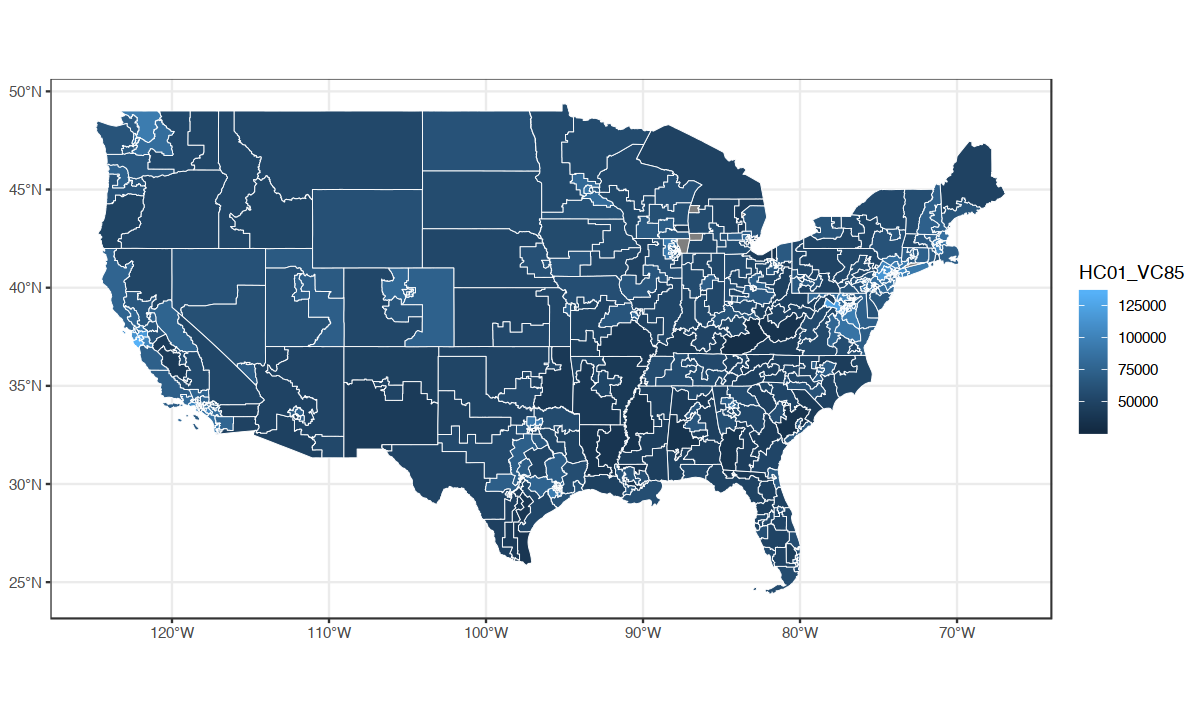

In [28]:
ggplot(dist_inc_115_conus) + geom_sf(aes(fill=HC01_VC85), color='white', size=.2) + theme_bw()

In [29]:
cong_115 <- htmltab('https://en.wikipedia.org/wiki/List_of_members_of_the_United_States_House_of_Representatives_in_the_115th_Congress_by_seniority') %>% 
    as_tibble %>% print

Argument 'which' was left unspecified. Choosing first table.
Warning message:
“Columns [Previous service,Committee and leadership positions] seem to have no data and are removed. Use rm_nodata_cols = F to suppress this behavior”

# A tibble: 450 x 5
   Rank  Representative    Party District        `Seniority date`
   <chr> <chr>             <chr> <chr>           <chr>           
 1 1     John Conyers      D     Michigan 13     January 3, 1965 
 2 2     Don Young         R     Alaska at-large March 6, 1973   
 3 3     Jim Sensenbrenner R     Wisconsin 5     January 3, 1979 
 4 4     Hal Rogers        R     Kentucky 5      January 3, 1981 
 5 5     Chris Smith       R     New Jersey 4    January 3, 1981 
 6 6     Steny Hoyer       D     Maryland 5      May 19, 1981    
 7 7     Marcy Kaptur      D     Ohio 9          January 3, 1983 
 8 8     Sander Levin      D     Michigan 9      January 3, 1983 
 9 9     Joe Barton        R     Texas 6         January 3, 1985 
10 10    Pete Visclosky    D     Indiana 1       January 3, 1985 
# … with 440 more rows


In [32]:
cong_115_dist <- mutate(cong_115, 
                        state = str_extract(District, "([A-Z][a-z]+ ?){1,2}"),
                        district = as.integer(str_extract(District, "\\d+$"))) %>% print

# A tibble: 450 x 7
   Rank  Representative   Party District      `Seniority date` state    district
   <chr> <chr>            <chr> <chr>         <chr>            <chr>       <int>
 1 1     John Conyers     D     Michigan 13   January 3, 1965  Michigan       13
 2 2     Don Young        R     Alaska at-la… March 6, 1973    Alaska         NA
 3 3     Jim Sensenbrenn… R     Wisconsin 5   January 3, 1979  Wiscons…        5
 4 4     Hal Rogers       R     Kentucky 5    January 3, 1981  Kentucky        5
 5 5     Chris Smith      R     New Jersey 4  January 3, 1981  New Jer…        4
 6 6     Steny Hoyer      D     Maryland 5    May 19, 1981     Maryland        5
 7 7     Marcy Kaptur     D     Ohio 9        January 3, 1983  Ohio            9
 8 8     Sander Levin     D     Michigan 9    January 3, 1983  Michigan        9
 9 9     Joe Barton       R     Texas 6       January 3, 1985  Texas           6
10 10    Pete Visclosky   D     Indiana 1     January 3, 1985  Indiana         1
# … with

In [33]:
dist_inc_cd_115 <- dist_inc_115_conus %>% mutate(district = as.integer(CD115FP)) %>%
    left_join(cong_115_dist, by=c("state", "district")) %>% print

Simple feature collection with 448 features and 24 fields
geometry type:  MULTIPOLYGON
dimension:      XY
bbox:           xmin: -124.849 ymin: 24.39631 xmax: -66.88544 ymax: 49.38436
epsg (SRID):    4269
proj4string:    +proj=longlat +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +no_defs
First 10 features:
   STATEFP CD115FP GEOID                          NAMELSAD LSAD CDSESSN MTFCC
1       10      00  1000 Congressional District (at Large)   C1     115 G5200
2       30      00  3000 Congressional District (at Large)   C1     115 G5200
3       38      00  3800 Congressional District (at Large)   C1     115 G5200
4       46      00  4600 Congressional District (at Large)   C1     115 G5200
5       50      00  5000 Congressional District (at Large)   C1     115 G5200
6       56      00  5600 Congressional District (at Large)   C1     115 G5200
7       01      01  0101          Congressional District 1   C2     115 G5200
8       04      01  0401          Congressional District 1   C2     115 G5200


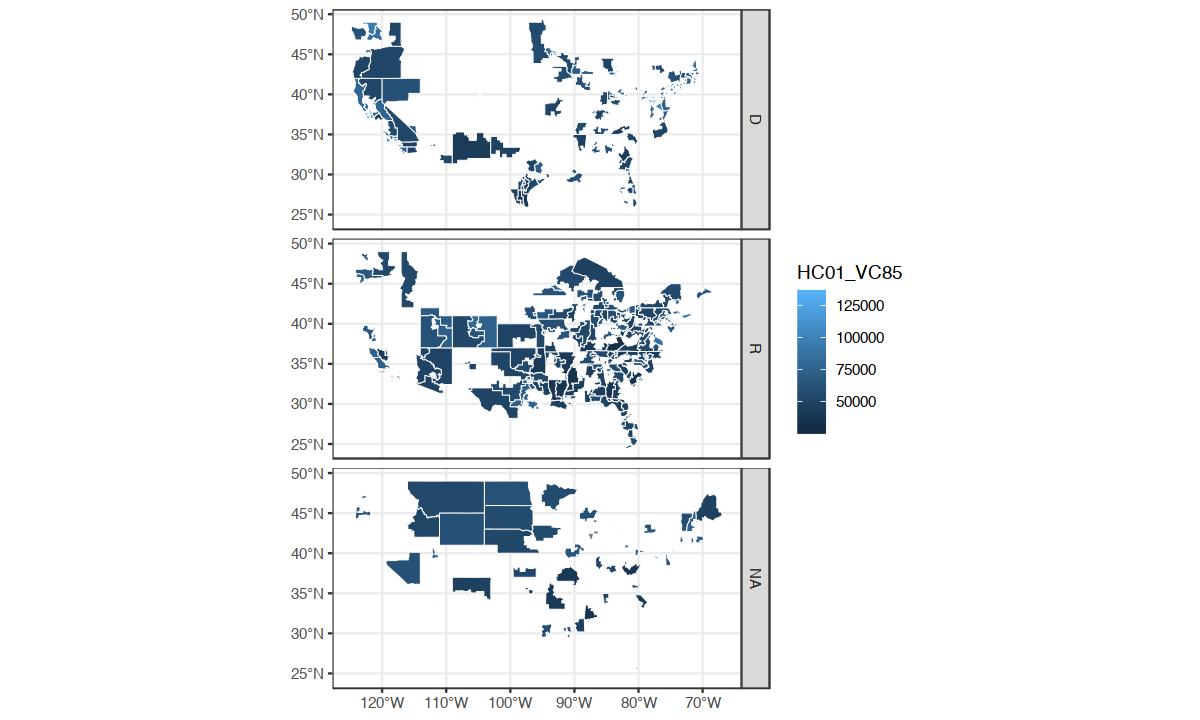

In [34]:
ggplot(dist_inc_cd_115) + geom_sf(aes(fill=HC01_VC85), color="white", size=.2) + 
    facet_grid(Party ~ .) + theme_bw()

## How has income inequality changed between R and D districts over the past 10 years?

Let us simply compare median income among `R` and `D` districts over the past 10 years:

In [40]:
select(dist_inc_cd_115, Party, HC01_VC85) %>% print 
# group_by(Party) %>% summarize(mean(HC01_VC85))

Simple feature collection with 448 features and 2 fields
geometry type:  MULTIPOLYGON
dimension:      XY
bbox:           xmin: -124.849 ymin: 24.39631 xmax: -66.88544 ymax: 49.38436
epsg (SRID):    4269
proj4string:    +proj=longlat +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +no_defs
First 10 features:
   Party HC01_VC85                       geometry
1   <NA>     62852 MULTIPOLYGON (((-75.78902 3...
2   <NA>     53386 MULTIPOLYGON (((-116.0491 4...
3   <NA>     61843 MULTIPOLYGON (((-104.049 48...
4   <NA>     56521 MULTIPOLYGON (((-104.0579 4...
5   <NA>     57513 MULTIPOLYGON (((-73.43771 4...
6   <NA>     60434 MULTIPOLYGON (((-111.0546 4...
7      R     47984 MULTIPOLYGON (((-88.46443 3...
8      R     50303 MULTIPOLYGON (((-114.0424 3...
9      R     41143 MULTIPOLYGON (((-92.95095 3...
10     D     51478 MULTIPOLYGON (((-123.7192 4...
